## Piecewise Linear Fit method for the IPO reconstruction using pyearth implementation of Friedman 1991 method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pandas import DataFrame
from scipy.stats import pearsonr,spearmanr

import os
import tempfile
import datetime
import subprocess
import shutil
from ipywidgets import widgets

In [2]:
import scipy
import sklearn
import pyearth
print(pyearth.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.1.0+16.g400f84d
1.6.0
0.24.1


In [4]:
myprefix="post_review"
today=datetime.date.today()
resultsdir='../results/{}_{}'.format(myprefix,today)
#if not os.path.exists(resultsdir):
#    os.makedirs(resultsdir) 
#    os.makedirs("{}/Mars".format(resultsdir))
#    shutil.copy('../results/mars.input', '{}/Mars/'.format(resultsdir))

In [5]:
ipo_index=np.loadtxt('data/IPO_av_from_monthly2020.csv',delimiter=",",skiprows=1)[:,1] #1872-2017
ipo_years=np.loadtxt('data/IPO_av_from_monthly2020.csv',delimiter=",",skiprows=1)[:,0]

LD_data=np.flipud(np.genfromtxt('data/DSS_2k_winter_centred.csv',delimiter=",",skip_header=1))
smooth_ipo=gaussian_filter(ipo_index,3.9) #Run a Gaussian filter with ~13 year fwhm over the IPO dataset 


In [7]:
#extract the instrumental period for the ice core data

accum_smooth=gaussian_filter(LD_data[-151:,8],3.9) #smooth the accumulation data

jjason=LD_data[-151:,10]
djfmam=LD_data[-151:,9]
ssyears=LD_data[-151:,1]


data_years=np.arange(1866,2017) # have ice core data to 2016
#lets just try for now with using all the data, smoothing edge effects included and then discard bits
reco_years=np.arange(1878,2012) # IPO data from with 13 year smooth, we can do reco from 1876-2011 (6 years either side)

corr_ss=np.zeros_like(djfmam)

In [8]:
# we use the correlation between the warm and cool sea salts, which gives better agreement than the individual datasets. 
# We use a 13 year window over the pearson correlation.
for i,v in enumerate(djfmam[:-12]):
    j=i+7 # output is centred in the 13 years
    #print(ssyears[j])
    s1=djfmam[i:i+13]
    s2=jjason[i:i+13]
    corr_ss[j]=pearsonr(s1,s2)[0]
    
    
# and now smooth the correlation coefficients with the 13-year gaussian window
ss_corr_smooth=gaussian_filter(corr_ss,3.9) 

#discard ends due to edge effects
ss_corr_smooth=ss_corr_smooth[12:-5]
accum=accum_smooth[12:-5]
ipo=smooth_ipo[6:-9]

In [10]:
#now create the datasets to feed into the EARTH model

in_dat=np.dstack((ss_corr_smooth,accum))[0]

#old_ipo=old_ipo[:-7]
#mars_in=np.dstack((ss_corr_smooth[6:-6],accum[6:-6],ipo[:-6]))[0]
#mars_in=np.dstack((ss_corr_smooth,accum,ipo))[0]
#mars_test=np.dstack((ss_corr_smooth,accum[6:-6],np.zeros_like(ipo)))[0]
#mars_test=np.dstack((ss_corr_smooth,accum,np.zeros_like(accum)))[0]

#np.savetxt('{}/Mars/IPO_mars_input.txt'.format(resultsdir),mars_in)
#np.savetxt('{}/Mars/IPO_mars_test.txt'.format(resultsdir),mars_test)

In [11]:
from pyearth import Earth
import math

model1=Earth(max_terms=9,max_degree=2,smooth='True',verbose=1)
model1.fit(in_dat,ipo)
y_hat=model1.predict(in_dat)
print(model1.trace())
print(model1.summary())




Beginning forward pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.672031  1      0.682  0.000  0.000  
1     0       0    104   0.214220  3      0.235  0.681  0.656  
2     2       1    78    0.201652  5      0.239  0.700  0.649  
3     0       1    -1    0.176655  6      0.218  0.737  0.680  
4     2       0    124   0.160126  8      0.216  0.762  0.684  
5     0       0    30    0.153061  10     0.225  0.772  0.670  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms
Beginning pruning pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   10     0.15  0.225  0.772  0.670  
1     8   9      0.15  0.215  0.772  0.684  
2     1   8      0.15  0.206  0.772

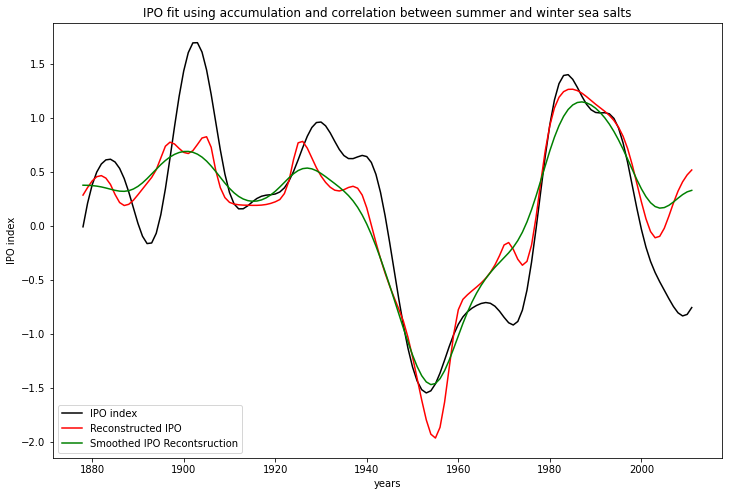

In [13]:

fig1,ax1=plt.subplots(figsize=[12,8])

ax1.plot(reco_years,ipo,'k')
ax1.plot(reco_years,y_hat,'r',)

ax1.plot(reco_years,gaussian_filter(y_hat,3.9),'g')

ax1.set_xlabel('years')
ax1.set_ylabel('IPO index')

#plt.ylabel('y')
ax1.legend(["IPO index","Reconstructed IPO","Smoothed IPO Recontsruction"])
plt.title('IPO fit using accumulation and correlation between summer and winter sea salts')
plt.show()
fig1.savefig('IPO_reconstruction_instrumental_PLF.png')

In [14]:
longaccum=gaussian_filter(accum_raw[1:,4],3.9)[6:-5]

sss_long=LD_ss_raw[:,1]
ssw_long=LD_ss_raw[:,2]

ss_corr_long=np.zeros(len(sss_long))

for i,v in enumerate(sss_long[:-12]):
    j=i+7
    s1=sss_long[i:i+13]
    s2=ssw_long[i:i+13]
    s2=s2[~np.isnan(s1)]
    s1=s1[~np.isnan(s1)]
    s1=s1[~np.isnan(s2)]
    s2=s2[~np.isnan(s2)]
    
    ss_corr_long[j]=pearsonr(s1,s2)[0]


#chop then smooth the whole correlation dataset 175-2010 (because we lose 6 years on the end for the correlation window)    
smooth_corr_long=gaussian_filter(ss_corr_long,3.9)[6:-5] 
longyears=np.arange(-4,2012)
print(len(smooth_corr_long),len(longyears),len(longaccum))


NameError: name 'accum_raw' is not defined

In [15]:
longaccum=gaussian_filter(LD_data[:,8],3.9)[7:-5]

sss_long=LD_data[:,9]
ssw_long=LD_data[:,10]
print(LD_data[7:-5,1])
ss_corr_long=np.zeros(len(sss_long))

for i,v in enumerate(sss_long[:-12]):
    j=i+7
    s1=sss_long[i:i+13]
    s2=ssw_long[i:i+13]
    s2=s2[~np.isnan(s1)]
    s1=s1[~np.isnan(s1)]
    s1=s1[~np.isnan(s2)]
    s2=s2[~np.isnan(s2)]
    ss_corr_long[j]=pearsonr(s1,s2)[0]

#chop then smooth the whole correlation dataset -4 to 2010 (because we lose 6 years on the end for the correlation window and smoothing)    
smooth_corr_long=gaussian_filter(ss_corr_long,3.9)[7:-5] 
longyears=np.arange(-4,2012)


[-4.000e+00 -3.000e+00 -2.000e+00 ...  2.009e+03  2.010e+03  2.011e+03]


In [16]:
long_indat=np.dstack((smooth_corr_long,longaccum))[0]
longipo=model1.predict(long_indat)
print(longipo)

np.savetxt('output_IPO_reconstruction_PLF.txt',np.dstack((longyears,smooth_corr_long,longaccum,longipo,gaussian_filter(longipo,3.9)))[0])




[0.31154461 0.23306462 0.16870064 ... 0.40586408 0.47022096 0.51580927]


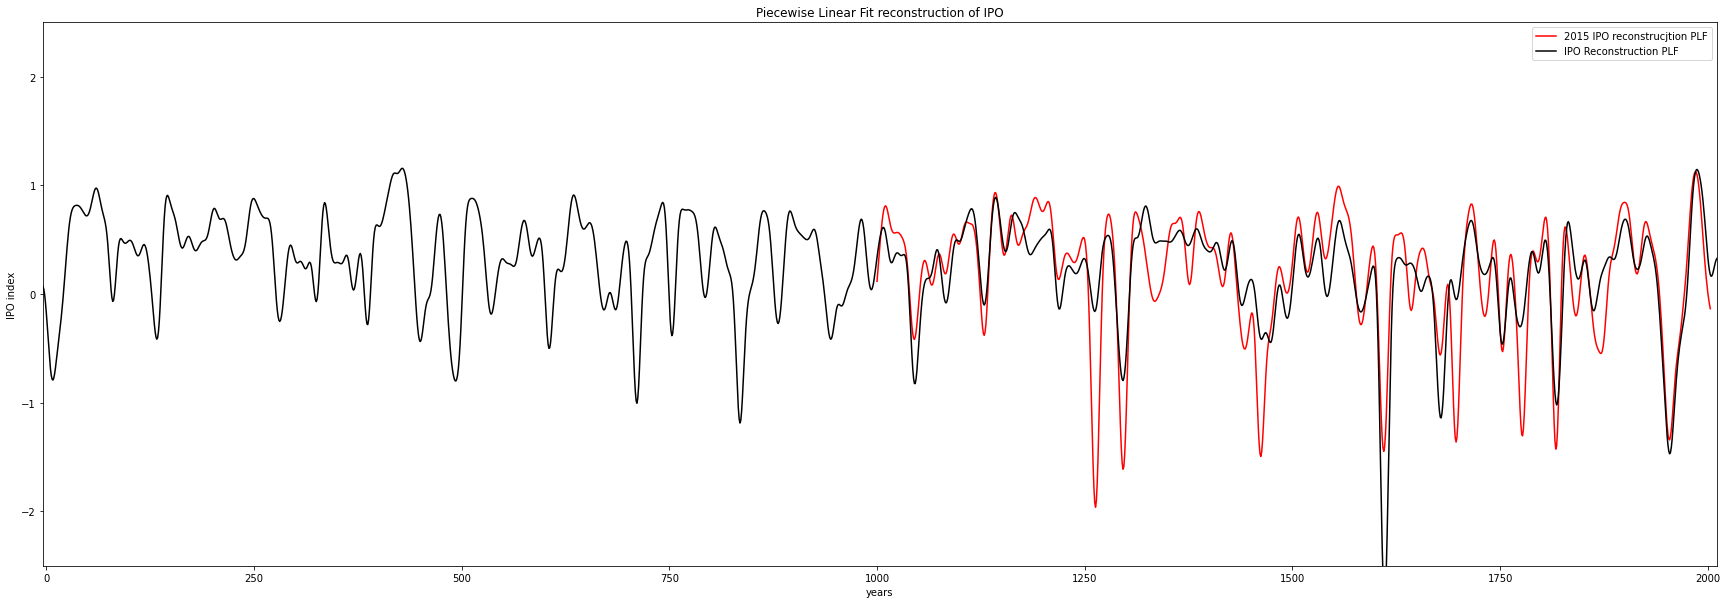

In [20]:
old_reco=np.loadtxt('data/oldreco_results.txt',delimiter=',',skiprows=1)

fig2,ax2_ipo=plt.subplots(1,1,figsize=[30,10])



ax2_ipo.plot(old_reco[:,0],old_reco[:,1],'r',label='2015 IPO reconstrucjtion PLF')
ax2_ipo.plot(longyears,gaussian_filter(longipo,3.9),'k',label='IPO Reconstruction PLF')
ax2_ipo.set_xlabel('Years')
ax2_ipo.set_ylabel('IPO index')

ax2_ipo.set_xlim([-4,2011])
ax2_ipo.set_ylim([-2.5,2.5])
ax2_ipo.legend()
plt.title('Piecewise Linear Fit reconstruction of IPO')
plt.show()
fig2.savefig('IPO_reconstruction_2kyears_PLF.png')